<a href="https://colab.research.google.com/github/yesiltepe-hidir/NVAE/blob/master/NVAE_LSUN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/yesiltepe-hidir/NVAE.git

Cloning into 'NVAE'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 85 (delta 6), reused 0 (delta 0), pack-reused 70
Unpacking objects: 100% (85/85), done.


In [1]:
!pip install tensorboardX
%cd /content/NVAE
!rm -rf eval-

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/NVAE


In [3]:
# Import libraries
import argparse
import torch
import torch.nn as nn
import numpy as np
import os

import torch.distributed as dist
from torch.multiprocessing import Process
from torch.cuda.amp import autocast, GradScaler

from model import AutoEncoder
from thirdparty.adamax import Adamax
import utils
import datasets

from fid.fid_score import compute_statistics_of_generator, load_statistics, calculate_frechet_distance
from fid.inception import InceptionV3

import matplotlib.pyplot as plt

In [5]:
# Get args
PATH = '/content/NVAE/checkpoint.pt'
checkpoint = torch.load(PATH)
args = checkpoint['args']

In [6]:
# Create Model
writer = utils.Writer(args.global_rank, args.save)
arch_instance = utils.get_arch_cells(args.arch_instance)
model = AutoEncoder(args, writer, arch_instance)
model = model.cuda()

MULT:  1.0
len log norm: 128
len bn: 92


In [7]:
# Load Model
model.load_state_dict(checkpoint['state_dict'])

# Initialize
os.environ['MASTER_ADDR'] = args.master_address
os.environ['MASTER_PORT'] = '6020'
torch.cuda.set_device(args.local_rank)
dist.init_process_group(backend='nccl', init_method='env://', rank=0, world_size=args.num_process_per_node)

In [22]:
samples = model.sample(1, 1)

torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 64, 64])
torch.Size([1, 32, 128, 128])
torch.Size([1, 32, 128, 128])
torch.Size([1, 32, 128, 128])


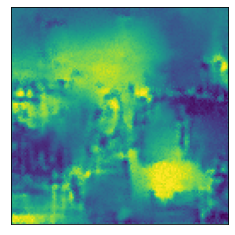

In [29]:
logit = model.image_conditional(samples[-1])
output = model.decoder_output(logit)
output_img = output.sample(16)
output_tiled = utils.tile_image(output_img, 1)
plt.imshow(output_tiled[0].cpu().detach().numpy())
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

In [30]:
!rm -rf church_outdoor_train_lmdb.zip church_outdoor_val_lmdab.zip church_outdoor_train_lmdb

# LSUN Church Dataset
!git clone https://github.com/fyu/lsun.git
!python3 lsun/download.py -c church_outdoor

# Unzip 
!unzip church_outdoor_train_lmdb.zip
!unzip church_outdoor_val_lmdb.zip

# Remove
!rm -rf lsun
!rm -rf church_outdoor_train_lmdb.zip
!rm -rf church_outdoor_val_lmdb.zip

Cloning into 'lsun'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 76 (delta 0), reused 0 (delta 0), pack-reused 75
Unpacking objects: 100% (76/76), done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2335M  100 2335M    0     0  8839k      0  0:04:30  0:04:30 --:--:-- 7762k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5817k  100 5817k    0     0  3845k      0  0:00:01  0:00:01 --:--:-- 3845k
Archive:  church_outdoor_train_lmdb.zip
   creating: church_outdoor_train_lmdb/
  inflating: church_outdoor_train_lmdb/lock.mdb  
  inflating: church_outdoor_train_lmdb/data.mdb  
Archive:  church_outdoor_val_lmdb.zip
   creating: church_outdoor_val_lmdb/
  inflating: church_outdoor_val_lmdb/lock.mdb  
  inflating: c

In [ ]:
!python3 train.py --dataset lsun_church_64 --epochs 4 --root /content/NVAE  --data /content/NVAE --save /eval- --batch_size 32

In [3]:
# Import libraries
import argparse
import torch
import torch.nn as nn
import numpy as np
import os

import torch.distributed as dist
from torch.multiprocessing import Process
from torch.cuda.amp import autocast, GradScaler

from model import AutoEncoder
from thirdparty.adamax import Adamax
import utils
import datasets

from fid.fid_score import compute_statistics_of_generator, load_statistics, calculate_frechet_distance
from fid.inception import InceptionV3

import matplotlib.pyplot as plt

In [4]:
# Get args
PATH = 'eval-/checkpoint.pt'
checkpoint = torch.load(PATH)
args = checkpoint['args']

In [5]:
# Create Model
writer = utils.Writer(args.global_rank, args.save)
arch_instance = utils.get_arch_cells(args.arch_instance)
model = AutoEncoder(args, writer, arch_instance)
model = model.cuda()

MULT:  1.0
len log norm: 128
len bn: 92


In [6]:
# Load Model
model.load_state_dict(checkpoint['state_dict'])

# Initialize
os.environ['MASTER_ADDR'] = args.master_address
os.environ['MASTER_PORT'] = '6020'
torch.cuda.set_device(args.local_rank)
dist.init_process_group(backend='nccl', init_method='env://', rank=0, world_size=args.num_process_per_node)

In [76]:
def visualize(model, n_samples):
  samples = model.sample(n_samples, 0.2)
  for i in range(1, 4):
    plt.rcParams['figure.figsize'] = (12, 12)
    plt.subplot(1, 3, i)
    logit = model.image_conditional(samples[i+2])
    output = model.decoder_output(logit)
    output_img = output.sample(1)
    output_tiled = utils.tile_image(output_img, int(n_samples**0.5))
    plt.imshow(output_tiled.permute(1, 2, 0).cpu().detach().numpy())
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
  plt.show()

In [66]:
samples = model.sample(4, 0.2)

torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 32, 64, 64])
torch.Size([4, 32, 64, 64])
torch.Size([4, 32, 64, 64])


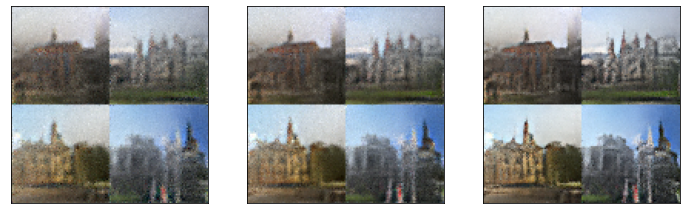

In [67]:
for i in range(1, 4):
  plt.rcParams['figure.figsize'] = (12, 12)
  plt.subplot(1, 3, i)
  logit = model.image_conditional(samples[i+2])
  output = model.decoder_output(logit)
  output_img = output.sample(1)
  output_tiled = utils.tile_image(output_img, 2)
  plt.imshow(output_tiled.permute(1, 2, 0).cpu().detach().numpy())
  plt.gca().axes.get_xaxis().set_visible(False)
  plt.gca().axes.get_yaxis().set_visible(False)

In [45]:
output_img.size()

torch.Size([16, 3, 64, 64])

torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 32, 64, 64])
torch.Size([4, 32, 64, 64])
torch.Size([4, 32, 64, 64])


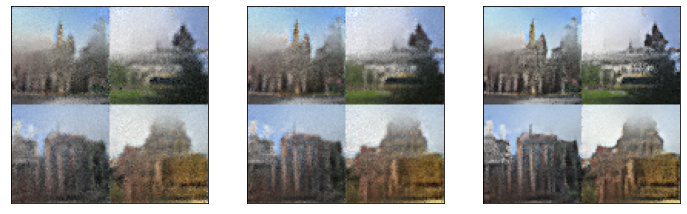

In [70]:
visualize(model)

torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 32, 64, 64])
torch.Size([4, 32, 64, 64])
torch.Size([4, 32, 64, 64])


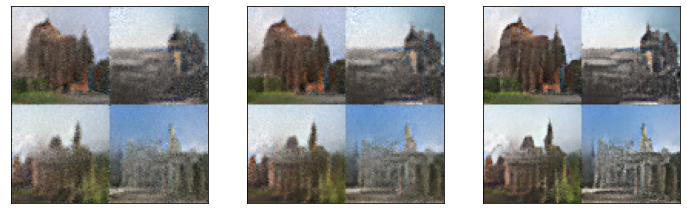

In [71]:
visualize(model)

torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 32, 64, 64])
torch.Size([4, 32, 64, 64])
torch.Size([4, 32, 64, 64])


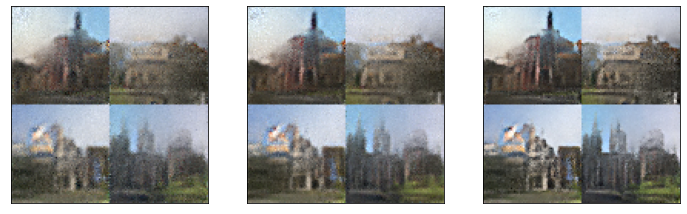

In [72]:
visualize(model)

torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 32, 64, 64])
torch.Size([4, 32, 64, 64])
torch.Size([4, 32, 64, 64])


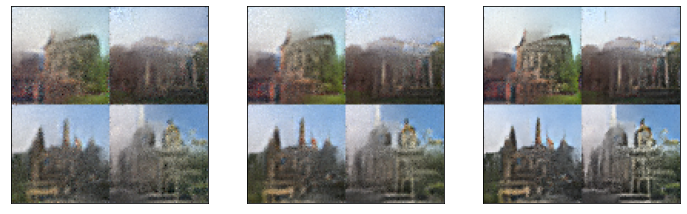

In [73]:
visualize(model)

torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 32, 64, 64])
torch.Size([4, 32, 64, 64])
torch.Size([4, 32, 64, 64])


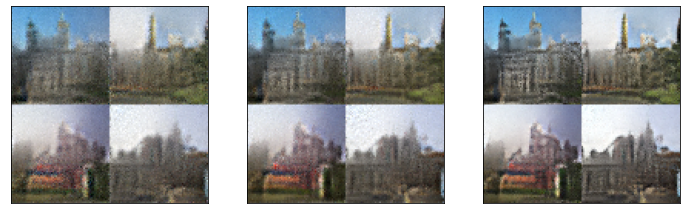

In [74]:
visualize(model)

torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 32, 64, 64])
torch.Size([4, 32, 64, 64])
torch.Size([4, 32, 64, 64])


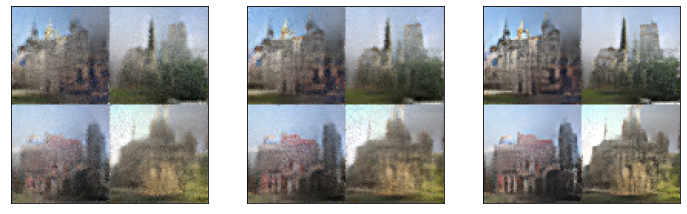

In [75]:
visualize(model)

torch.Size([16, 64, 32, 32])
torch.Size([16, 64, 32, 32])
torch.Size([16, 64, 32, 32])
torch.Size([16, 32, 64, 64])
torch.Size([16, 32, 64, 64])
torch.Size([16, 32, 64, 64])


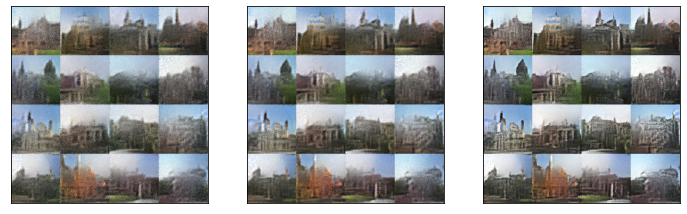

In [77]:
visualize(model, 16)

torch.Size([16, 64, 32, 32])
torch.Size([16, 64, 32, 32])
torch.Size([16, 64, 32, 32])
torch.Size([16, 32, 64, 64])
torch.Size([16, 32, 64, 64])
torch.Size([16, 32, 64, 64])


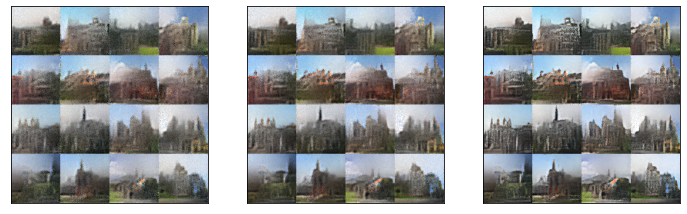

In [78]:
visualize(model, 16)

torch.Size([16, 64, 32, 32])
torch.Size([16, 64, 32, 32])
torch.Size([16, 64, 32, 32])
torch.Size([16, 32, 64, 64])
torch.Size([16, 32, 64, 64])
torch.Size([16, 32, 64, 64])


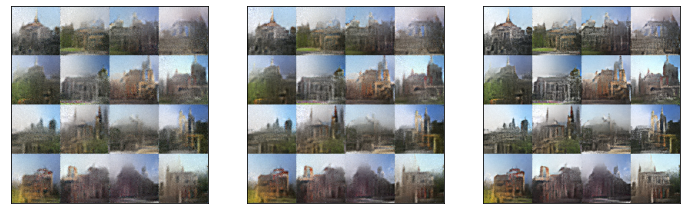

In [79]:
visualize(model, 16)

torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 32, 64, 64])
torch.Size([4, 32, 64, 64])
torch.Size([4, 32, 64, 64])


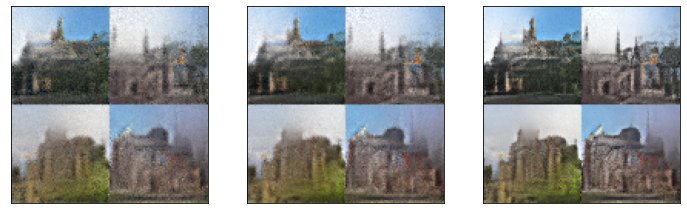

In [86]:
visualize(model, 4)

torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 32, 64, 64])
torch.Size([4, 32, 64, 64])
torch.Size([4, 32, 64, 64])


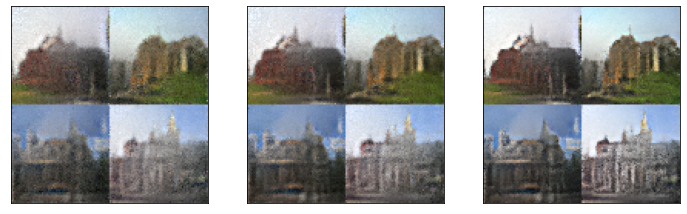

In [88]:
visualize(model, 4)